# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "jpmvSIjdWwZ5EK6h0Bsq4Bmh7"
CONSUMER_SECRET = "hKCCLawMROms8S7yTmi4wakmdjaBIMQON9FOdXu0uSczetuNt6"

ACCESS_TOKEN_KEY = "288346150-0VadQaY0EEIU9kSr4TLx49nQkf1tQcPNQbc5KM6X"
ACCESS_TOKEN_SECRET = "G6tvI1c7Hq35shEFXCQjBrLLAtbHfV5wwHGtozcD73onS"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [124]:
def clean_tweet(tweet):
    tweet = tweet.AsDict()
    
    if "media" in tweet or tweet["lang"] != "en":
        return -1
    
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet["text"])
    mentions = re.findall('@(?:[a-zA-Z]|[0-9]|[_])+', tweet["text"])
    
    for url_or_mention in urls + mentions:
        tweet["text"] = tweet["text"].replace(url_or_mention, "")
        
    return tweet

def get_user_tweets(user_id):
    try:
        tweets = api.GetUserTimeline(user_id=user_id, count=200, exclude_replies=True, include_rts=False)
    except:
        return -1
    
    good_tweets = []
    for tweet in tweets:
        tweet = clean_tweet(tweet)
        if tweet != -1:
            good_tweets.append(tweet)
            
    if len(good_tweets) == 0:
        return -1
            
    return good_tweets

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [107]:
from nltk.tokenize import word_tokenize
def get_words(text):
    words = []
    blocks = word_tokenize(text)
    for block in blocks:
        block = re.findall('[a-zA-Z]', block)
        if len(block) != 0:
            words.append("".join(block))
    return words

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [39]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [217]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

def get_tokens(words):
    tokens = []
    wnl = WordNetLemmatizer()
    
    stop_words = set(stopwords.words("english"))
    
    for word in words:
        word = word.lower()
        if word not in stop_words:
            tokens.append(wnl.lemmatize(word))
        
    return tokens

Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [122]:
def get_tweet_tokens(tweet):
    text = tweet["text"]
    return get_tokens(get_words(text))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [153]:
from collections import Counter

def collect_users_tokens(df_users):
    users = [] # users list
    users_tokens = [] # list of user dicts
    
    counter = 0
    
    for user in df_users["uid"]:
        tokens = []
        tweets = get_user_tweets(user)
        
        if tweets != -1:
            for tweet in tweets:
                tweet_tokens = get_tweet_tokens(tweet)
                if len(tweet_tokens) > 0: 
                    tokens.extend(tweet_tokens)
        
        record = Counter(tokens)
        record = dict(record)

        if record:
            users_tokens.append(dict(record))
            users.append(user)
        
        counter += 1
        if counter % 500 == 0:
            print counter
    
    return users, users_tokens

In [159]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500


In [161]:
import numpy as np
np.savez("out.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [215]:
def draw_tag_cloud(v, vs):
    text = ""
    user_tokens = v.inverse_transform(vs)
    words = Counter()

    for tokens in user_tokens:
        words += Counter(tokens)
        
    most_common = words.most_common(100)
    
    for common_tuple in most_common:
        text += (common_tuple[0] + " ") * int(common_tuple[1])
        
    wordcloud = WordCloud(background_color='white').generate(text)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('wordcloud.png', dpi=500)
    plt.show()
        
    return

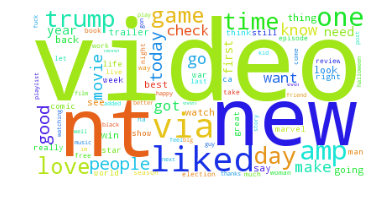

In [216]:
draw_tag_cloud(v, vs)